From the univariate analysis notebook, 

https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/univariate-analysis-regression-lb-0-006/notebook

it seems we are getting a good score if we use the variable 'technical_20' and build a model. However if we use the top 4 variables and build a model, we are getting a negative public score though our local validation score improved to 0.0195. So how do we tackle this?

Also from the kagglegym api, we get the rewards (R value) for individual timestamps and finally for the whole test data set. These individual rewards are very hard to make sense since it is highly influenced by the mean target value of the given timestamp. 

So I thought probably **looking at the cumulative R value till the given timestamp** might help a little more (as mean target values are averaged over all the points till the given timestamp) to build a more robust model and here is an attempt to understand the performance of some of the top public scripts.

Kindly upvote if you find this useful and / or share your comments. 

In [1]:
# Import all the necessary packages 
import kagglegym
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read the full data set stored as HDF5 file
full_df = pd.read_hdf('../input/train.h5')

Opening ../input/train.h5 in read-only mode


In [3]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [4]:
# Some pre-processing as seen from most of the public scripts.
# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()
target_var = 'y'

# Get the train dataframe
train = observation.train
mean_values = train.median(axis=0)
train.fillna(mean_values, inplace=True)

# Observed with histograns:
low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)

**Ridge Regression:**

The base script can be seen here

https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/

We shall first run a univariate ridge regression using 'technical_20' variable alone and see how the cumulative R value changes over time. 



In [5]:
### https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/run/545100
# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()

# cols_to_use for ridge model
#cols_to_use = ['technical_30', 'technical_20', 'fundamental_11']
cols_to_use = ['technical_20']

# model build
model = Ridge()
model.fit(np.array(train.loc[y_is_within_cut, cols_to_use].values), train.loc[y_is_within_cut, target_var])

# getting the y mean dict for averaging
ymean_dict = dict(train.groupby(["id"])["y"].mean())

# weighted average of model & mean
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
r1_overall_reward_list = []
ts_list = []
while True:
    timestamp = observation.features["timestamp"][0]
    actual_y = list(full_df[full_df["timestamp"] == timestamp]["y"].values)
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use].values)
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    
    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    target = observation.target
    observation, reward, done, info = env.step(target)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    pred_y = list(target.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    r1_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    if done:
        break
    
print(info)

Timestamp #1000
Timestamp #1100
Timestamp #1200
Timestamp #1300
Timestamp #1400
Timestamp #1500
Timestamp #1600
Timestamp #1700
Timestamp #1800
{'public_score': 0.017155811636456242}


We are getting a final R score of 0.01751 using this model. Now let us look at how the cumulative R value changes over time by plotting it along with zero-line.

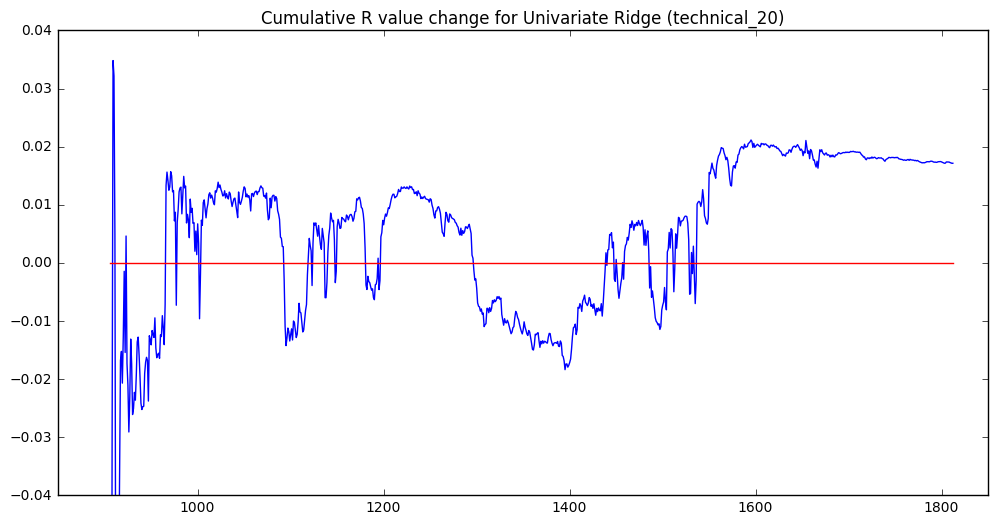

In [6]:
fig = plt.figure(figsize=(12, 6))
plt.plot(ts_list, r1_overall_reward_list, c='blue')
plt.plot(ts_list, [0]*len(ts_list), c='red')
plt.title("Cumulative R value change for Univariate Ridge (technical_20)")
plt.ylim([-0.04,0.04])
plt.xlim([850, 1850])
plt.show()

As we could clearly see, the cumulative R values are not positive throughout. 

Even after initial ~400 timestamps (meaning we have considerable amount of data), the cumulative R value went below the zero mark (I think this is due to the nature of the data we are dealing with). And finally the cumulative R values went above zero mark and stayed there till the end. 

So there is a possibility of R value ending up less than 0 in the private test set.! 

Now let us use two variables and build the ridge model.


In [7]:
### https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/run/545100
# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()

# cols_to_use for ridge model
#cols_to_use = ['technical_30', 'technical_20', 'fundamental_11']
cols_to_use = ['technical_30', 'technical_20']

# model build
model = Ridge()
model.fit(np.array(train.loc[y_is_within_cut, cols_to_use].values), train.loc[y_is_within_cut, target_var])

# getting the y mean dict for averaging
ymean_dict = dict(train.groupby(["id"])["y"].mean())

# weighted average of model & mean
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
r2_overall_reward_list = []
ts_list = []
while True:
    timestamp = observation.features["timestamp"][0]
    actual_y = list(full_df[full_df["timestamp"] == timestamp]["y"].values)
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use].values)
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    
    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    target = observation.target
    observation, reward, done, info = env.step(target)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    pred_y = list(target.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    r2_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    if done:
        break
    
print(info)

Timestamp #1000
Timestamp #1100
Timestamp #1200
Timestamp #1300
Timestamp #1400
Timestamp #1500
Timestamp #1600
Timestamp #1700
Timestamp #1800
{'public_score': 0.019403514350348074}


The final R value of 0.019 is better than the previous one of 0.017

We can plot both the previous model and the current model to see how the cumulative R value changes for both the models.

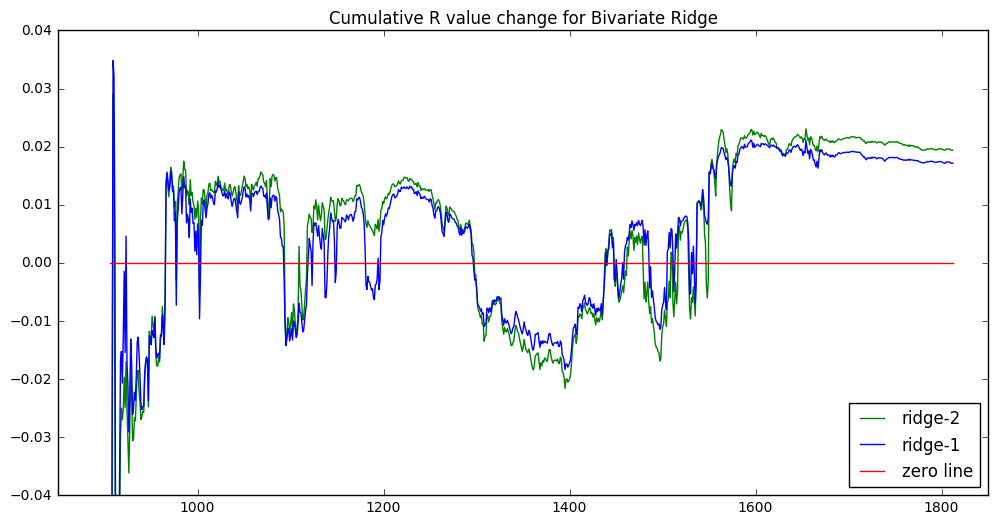

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_list, r2_overall_reward_list, c='green', label='ridge-2')
ax.plot(ts_list, r1_overall_reward_list, c='blue', label='ridge-1')
ax.plot(ts_list, [0]*len(ts_list), c='red', label='zero line')
ax.legend(loc='lower right')
ax.set_ylim([-0.04,0.04])
ax.set_xlim([850, 1850])
plt.title("Cumulative R value change for Bivariate Ridge")
plt.show()

There is not much of a change in the trend for both the models as we can see. 

In most places, when the R value is above zero mark, bivariate ridge gave better scores than univariate one. On the contrary, when the scores are less than 0, univariate gave better scores than bivariate. 

Now let us add the third variable 'fundamental_11' to our ridge model (public LB score 0.010) and see the results. 
https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/run/545656

In [9]:
### https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/run/545100
# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()

# cols_to_use for ridge model
cols_to_use = ['technical_30', 'technical_20', 'fundamental_11']

# model build
model = Ridge()
model.fit(np.array(train.loc[y_is_within_cut, cols_to_use].values), train.loc[y_is_within_cut, target_var])

# getting the y mean dict for averaging
ymean_dict = dict(train.groupby(["id"])["y"].mean())

# weighted average of model & mean
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
r3_overall_reward_list = []
ts_list = []
while True:
    timestamp = observation.features["timestamp"][0]
    actual_y = list(full_df[full_df["timestamp"] == timestamp]["y"].values)
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use].values)
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    
    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    target = observation.target
    observation, reward, done, info = env.step(target)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    pred_y = list(target.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    r3_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    if done:
        break
    
print(info)

Timestamp #1000
Timestamp #1100
Timestamp #1200
Timestamp #1300
Timestamp #1400
Timestamp #1500
Timestamp #1600
Timestamp #1700
Timestamp #1800
{'public_score': 0.019464318277382934}


There is a very slight improvement in the validation R score from 0.01940 0.01946.

Now let us look at the cumulative R score plots of both the models as well.

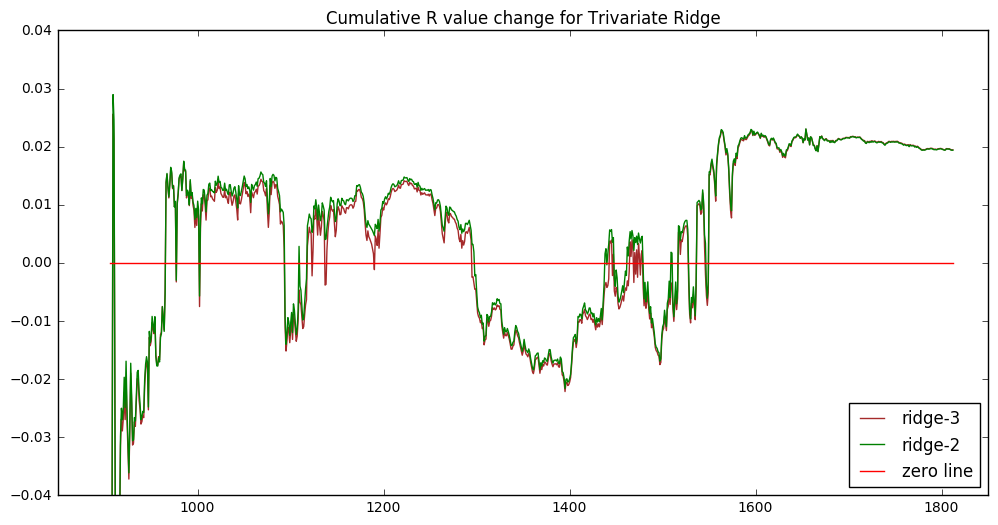

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_list, r3_overall_reward_list, c='brown', label='ridge-3')
ax.plot(ts_list, r2_overall_reward_list, c='green', label='ridge-2')
ax.plot(ts_list, [0]*len(ts_list), c='red', label='zero line')
ax.legend(loc='lower right')
ax.set_ylim([-0.04,0.04])
ax.set_xlim([850, 1850])
plt.title("Cumulative R value change for Trivariate Ridge")
plt.show()

As we could see, both these lines go together most of the times with trivariate score marginally below bivariate line in some cases. 

From the above three models, we can see that the trend remains same for all three models (of course all belong to same model family). 

Thanks to @the1owl, we got a great script which combines Extra trees with ridge to get a good score in the public LB 
https://www.kaggle.com/the1owl/two-sigma-financial-modeling/initial-script

Let us build the extra trees model and see how the cumulative R value changes. We shall use 25 trees instead of 100 just for the sake of run time.


In [11]:
env = kagglegym.make()
o = env.reset()

excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
col = [c for c in o.train.columns if c not in excl]

train = o.train[col]
d_mean= train.median(axis=0)

train = o.train[col]
n = train.isnull().sum(axis=1)
for c in train.columns:
    train[c + '_nan_'] = pd.isnull(train[c])
    d_mean[c + '_nan_'] = 0
train = train.fillna(d_mean)
train['znull'] = n

print("Building ET..")
model_et = ExtraTreesRegressor(n_estimators=25, max_depth=4, n_jobs=-1, random_state=123, verbose=0)
model_et.fit(train, o.train['y'])


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Building ET..


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=25, n_jobs=-1, oob_score=False, random_state=123,
          verbose=0, warm_start=False)

In [12]:
env = kagglegym.make()
o = env.reset()

#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
et_overall_reward_list = []
ts_list = []
while True:
    timestamp = o.features["timestamp"][0]
    actual_y = list(full_df[full_df["timestamp"] == timestamp]["y"].values)
    
    test = o.features[col]
    n = test.isnull().sum(axis=1)
    for c in test.columns:
        test[c + '_nan_'] = pd.isnull(test[c])
    test = test.fillna(d_mean)
    test['znull'] = n
    
    pred = o.target
    pred['y'] = model_et.predict(test).clip(low_y_cut, high_y_cut) 
    pred['y'] = pred.apply(get_weighted_y, axis = 1)
    o, reward, done, info = env.step(pred[['id','y']])
    
    pred_y = list(pred.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    et_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    if done:
        print(info)
        break

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Timestamp #1000
Timestamp #1100
Timestamp #1200
Timestamp #1300
Timestamp #1400
Timestamp #1500
Timestamp #1600
Timestamp #1700
Timestamp #1800
{'public_score': 0.021516721600245925}


Let us look at how the R value of the Extra trees model along with univariate ridge model (since univariate ridge is used in best public script)

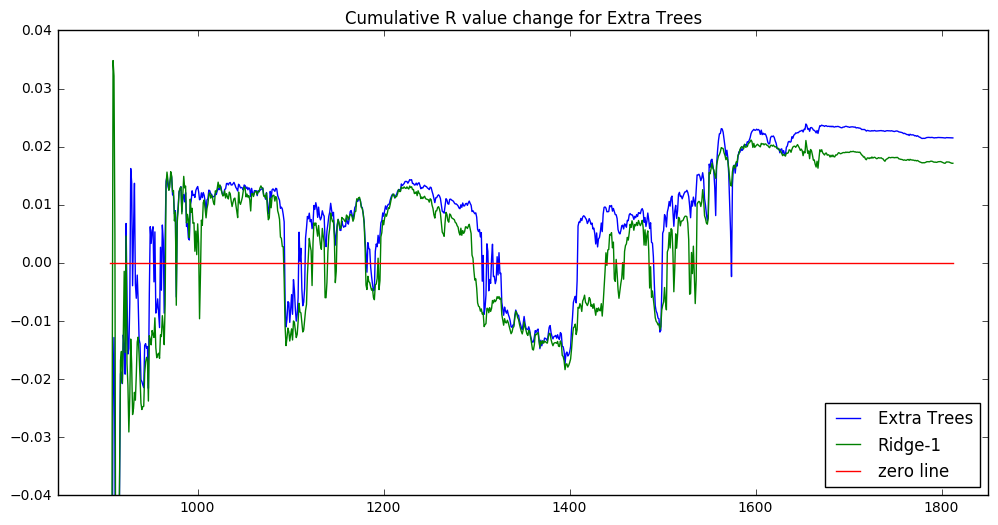

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_list, et_overall_reward_list, c='blue', label='Extra Trees')
ax.plot(ts_list, r1_overall_reward_list, c='green', label='Ridge-1')
ax.plot(ts_list, [0]*len(ts_list), c='red', label='zero line')
ax.legend(loc='lower right')
ax.set_ylim([-0.04,0.04])
ax.set_xlim([850, 1850])
plt.title("Cumulative R value change for Extra Trees")

plt.show()

The macro trend remains almost similar. R value of both the models dip below 0 in the intermediate time stamps and is above zero towards the end.

But we can also clearly notice that there is some variability in the Extra Tress model when compared with the ridge model. I think this helps in the model prediction when both are combined together. I also think this is the reason we are getting an improvement in the public LB score. 

**Inferences:**

If we could build a model which predicts good for the sub-zero R value timestamps (my hunch says it is hard though) and combine it with our existing best performing public models, it may be a good way to hedge the risk of overfitting.

Combining many models together might also be helpful to combat the overfitting risk (as it is proved by the best public script as well).

Happy Kaggling. Thank you.!